In [1]:
import sympy as syp
import numpy as np
import itertools

from qutip import ket, bra, tensor

from sympy import symbols, Matrix

si = Matrix([ [1,0], [0,1] ])
sx = Matrix([ [0,1],[1,0] ])
sy = Matrix([ [0,-1.0j], [1.0j, 0]])
sz = Matrix([ [1,0], [0,-1]])


def matrix_decomposition(matrix:np.array, basis:list[np.array]):
    # decomposes matrix  into defined basis (may be incomplete)
    # returns coeficients of that decomposition and residual such that
    # matrix = sum( coeficients*basis ) + residual
    matrix_shape = matrix.shape
    matrix_flat = matrix.flatten()
    
    basis_flat = [b.flatten() for b in basis]
    coeficients = [ matrix_flat.dot(b)/(b.dot(b)) for b in basis_flat ]
    residual = matrix - sum([ci*bi  for ci, bi in zip(coeficients,basis )])

    return coeficients, residual

def get_Hamiltonian_from_Unitary(unitary):
    P, D = unitary.diagonalize()
    phases = syp.Array([syp.arg(x) for x in D.diagonal()]) # extract complex phases
    epsilons = -phases # eigenvalues of the Hamiltonian

    return  P * syp.Matrix.diag(epsilons) * syp.MatPow(P, -1)

def spin_tensors(N):
    si_list = [si]*N
    siN = syp.KroneckerProduct(*si_list)
    sx_i = [None]*N 
    sy_i = [None]*N
    sz_i = [None]*N
    for i in range(N):
        for j in range(N): 
            st = si_list.copy()
            st[j] = sx
            sx_i[i] = syp.KroneckerProduct(*st).as_explicit()

            st = si_list.copy()
            st[j] = sy
            sy_i[i] = syp.KroneckerProduct(*st).as_explicit()

            st = si_list.copy()
            st[j] = sz
            sz_i[i] = syp.KroneckerProduct(*st).as_explicit()

    return siN.as_explicit(), sx_i, sy_i, sz_i



In [9]:
from sympy import exp, I
th, a, b = symbols('th a b')

expr = exp(-I* (a*sx+b*sy))

expr.simplify()

Matrix([
[                               1.0*cosh((-a**2 - b**2)**0.5), 0.5*(I*a + b - (I*a + b)*exp(2*(-a**2 - b**2)**0.5))*exp(-(-a**2 - b**2)**0.5)/(-a**2 - b**2)**0.5],
[-1.0*(-a**2 - b**2)**0.5*sinh((-a**2 - b**2)**0.5)/(I*a + b),                                                                      1.0*cosh((-a**2 - b**2)**0.5)]])

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(5)

qc.h(range(4))


qc.draw(output='latex')




## tests

In [183]:
a, b, t, r = symbols('a b t r')

si, sx_i, sy_i, sz_i = spin_tensors(2)
CNOT = Matrix([ [1,0,0,0],[0,1,0,0],[0,0,0,1], [0,0,1,0]])


# Base change matrix P,  diagonal matrix D
P, D = CNOT.diagonalize()

phases = syp.Array([syp.arg(x) for x in D.diagonal()]) # extract complex phases
epsilons = -phases # eigenvalues of the Hamiltonian

H =  P * syp.Matrix.diag(epsilons) * syp.MatPow(P, -1)

In [ ]:
coupling_list = []
basis_raw = []

cp_names = {'X':sx_i, 'Y':sy_i, 'Z':sz_i}

# generate for every pair of qubits
for a,b in itertools.product('IXYZ', repeat=2):
    coupling_list.append(f"{a}{b}")
    s0 = si
    s1 = si
    if a != 'I':
        s0 = cp_names[a][0]
    if b != 'I':
        s1 = cp_names[b][1]
    basis_raw.append(s0*s1)

# basis_raw +=  [CNOT]

# basis_raw = [ si ] + sx_i + sz_i + [sx_i[0]*sx_i[1]] +[sy_i[0]*sy_i[1]] + [sz_i[0]*sz_i[1]] + [ sz_i[0]*sy_i[1] ] + [ sy_i[0]*sz_i[1] ] + [ sy_i[0]*sx_i[1] ] + [ sx_i[0]*sy_i[1] ] 
# + sy_i + sz_i 
# oh no, it requires asymetric couplings ...
basis = [np.array(b.tolist()) for b in basis_raw]
coef, residual = matrix_decomposition( np.array(H.tolist()), basis )

for cn, c in zip(coupling_list, coef):
    print(f"{cn}: {c}")

print(f"residual: \n{residual}")

In [181]:
H

Matrix([
[0, 0,     0,     0],
[0, 0,     0,     0],
[0, 0, -pi/2,  pi/2],
[0, 0,  pi/2, -pi/2]])

In [188]:
matrix_decomposition(basis[0], basis)

([4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4.00000000000000, 0, 0, 0, 0, 4, 2],
 array([[-17.0000000000000, 0, 0, 0],
        [0, -17.0000000000000, 0, 0],
        [0, 0, -15.0000000000000, -2],
        [0, 0, -2, -15.0000000000000]], dtype=object))

##  Testing Rydberg interactions

In [4]:
ket('0')

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

In [20]:
H1ry = lambda a,b: ket(f'{a}')*bra(f'{b}')
H2ry = lambda a,b,c,d: ket(f'{a}{b}')*bra(f'{c}{d}')

A, B = symbols('A B')

CUxy = Matrix([[A, B, 0,0], [B.conjugate(), A, 0,0], [0,0,1,0], [0,0,0,1]])
H_CUxy = Matrix([[0,A,0,0],[A,0,0,0],[0,0,0,A],[0,0,A,B]])



In [14]:
get_Hamiltonian_from_Unitary(CUxy)

Matrix([
[                                                 -arg(A - sqrt(B*conjugate(B)))/2 - arg(A + sqrt(B*conjugate(B)))/2, B*arg(A - sqrt(B*conjugate(B)))/(2*sqrt(B*conjugate(B))) - B*arg(A + sqrt(B*conjugate(B)))/(2*sqrt(B*conjugate(B))), 0, 0],
[sqrt(B*conjugate(B))*arg(A - sqrt(B*conjugate(B)))/(2*B) - sqrt(B*conjugate(B))*arg(A + sqrt(B*conjugate(B)))/(2*B),                                                  -arg(A - sqrt(B*conjugate(B)))/2 - arg(A + sqrt(B*conjugate(B)))/2, 0, 0],
[                                                                                                                  0,                                                                                                                   0, 0, 0],
[                                                                                                                  0,                                                                                                                   0, 0, 0]])

In [21]:
(-1.0j*H_CUxy).exp()

Matrix([
[ 0.5*exp(I*A) + 0.5*exp(-I*A), -0.5*exp(I*A) + 0.5*exp(-I*A),                                                                                                                                                                                                                                                                                                                                    0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       0],
[-0.5*exp(I*A) + 0.5*exp(-I*A),  0.5*exp(I*A) + 

## Phase Out/In gates

"Phase In" gate $\widetilde R_i$

<img src="CircuitDraw/QFT1-000001.png" alt="drawing" width="300"/>

"Phase Out" gate $\widetilde S_i$

<img src="CircuitDraw/QFT2-000001.png" alt="drawing" width="300"/>

<!-- ![](CircuitDraw/QFT2-000001.png) -->

In [57]:
# "Phase out"  gate S_2, 3 qubits
from sympy import  Identity, exp, I, KroneckerProduct, pi

a, b = symbols('a b')

iden = Identity(2**3)
Z = Matrix([[1,0],[0,-1]])

C0R1 = Matrix(iden.as_explicit())
C0R1[7,7] = exp(I*a)
C0R1[6,6] = exp(I*a)

C0R2 = Matrix(iden.as_explicit())
C0R2[7,7] = exp(I*b)
C0R2[5,5] = exp(I*b)

cr = C0R1*C0R2
cr.simplify()

In [50]:
Rp = lambda p: Matrix([[1,0],[0,p]])

Z0Z2 = KroneckerProduct(Z, Identity(2), Z)
Z0Z1 = KroneckerProduct(Z, Z, Identity(2))
Z1Z2 = KroneckerProduct(Identity(2), Z, Z)

R0 = lambda p: KroneckerProduct(Rp(p), Identity(2), Identity(2))
R1 = lambda p: KroneckerProduct(Identity(2), Rp(p), Identity(2))
R2 = lambda p: KroneckerProduct(Identity(2), Identity(2),Rp(p))

c0, c1, c2 = symbols('c0 c1 c2')
d0, d1, d2 = symbols('d0 d1 d2')

mat = (c0*Z0Z1 + c1*Z0Z2 + c2*Z1Z2) + R0(d0) + R1(d1) + R2(d2)


In [58]:
m = mat.as_explicit()

m.diagonal()



Matrix([[Mod(c0 + c1 + c2, 1), Mod(c0 - c1 - c2 + d2, 1), Mod(-c0 + c1 - c2 + d1, 1), Mod(-c0 - c1 + c2 + d1 + d2, 1), Mod(-c0 - c1 + c2 + d0, 1), Mod(-c0 + c1 - c2 + d0 + d2, 1), Mod(c0 - c1 - c2 + d0 + d1, 1), Mod(c0 + c1 + c2 + d0 + d1 + d2, 1)]])

In [61]:
cr.diagonal()

Matrix([[1, 1, 1, 1, 1, exp(I*b), exp(I*a), exp(I*(a + b))]])

## MultiPhase gate

Phase In = Phase Out -> renamed to MultiPhase

$V_{ij} \sim 2^{(i-j)/p}$
where $p=3$ if dipole-dipole, or $p=6$ if vdW


### Lattice geometry approach 

$|\vec r_i - \vec r_j| = R^{j-i}$, with $R = 2^{1/p}$ 

The approach is valid, in a first approximation, if $R^n < n R$


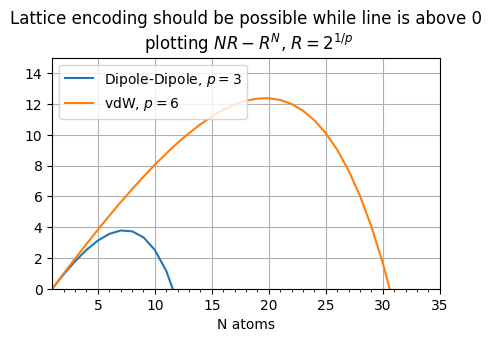

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


nr = np.array([*range(35)])

R = lambda p: np.power(2,1/p)
f, ax = plt.subplots(figsize=(5,3))

plt.title("Lattice encoding should be possible while line is above 0\n plotting $N R - R^N$, $R=2^{1/p}$")
plt.plot(nr, nr*R(3)-np.power(R(3), nr), label='Dipole-Dipole, $p=3$')
plt.plot(nr, nr*R(6)-np.power(R(6), nr), label='vdW, $p=6$')

ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel("N atoms")
plt.xlim((1,35))
plt.ylim((0,15))
plt.grid(True)
# plt.xticks()
plt.legend(loc='upper left')

plt.savefig("./Plots/lattice-encoding-condition.png", bbox_inches='tight')
plt.show()



Lets figure out the geometry of the atoms

$\vec r_0=0$

$\vec r_1 = R \vec e_x$

$ \vec r_2 = \vec r_1 + R (-cos\ \theta\ \vec e_x + sin\ \theta\ \vec e_y) $

$|\vec r_0-\vec r_2| = R^2 \implies cos \ \theta = 1-R^2/2$


In [28]:
th3 =np.arccos(1-R(3)**2/2)
th6 = np.arccos(1-R(6)**2/2)

print(f"D-D (p=3): theta={th3/np.pi} pi")
print(f"vdW (p=6): theta={th6/np.pi} pi")

th3 * 180/np.pi

D-D (p=3): theta=0.43385789109398604 pi
vdW (p=6): theta=0.3793441564891036 pi


78.09442039691749